In [3]:
import torch
import sympy
import numpy as np

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("SymPy version:", sympy.__version__)
print("Numpy version:", np.__version__)


Torch version: 2.4.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce GTX 1650
SymPy version: 1.13.3
Numpy version: 1.24.4


In [2]:
pip install sympy

   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.2 MB ? eta -:--:--
   --- ------------------------------------ 0.5/6.2 MB 1.5 MB/s eta 0:00:04
   ---------- ----------------------------- 1.6/6.2 MB 2.8 MB/s eta 0:00:02
   --------------- ------------------------ 2.4/6.2 MB 3.4 MB/s eta 0:00:02
   ---------------------- ----------------- 3.4/6.2 MB 3.9 MB/s eta 0:00:01
   ------------------------- -------------- 3.9/6.2 MB 3.8 MB/s eta 0:00:01
   ---------------------------- ----------- 4.5/6.2 MB 3.4 MB/s eta 0:00:01
   -------------------------------- ------- 5.0/6.2 MB 3.1 MB/s eta 0:00:01
   ------------------------------------- -- 5.8/6.2 MB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 6.2/6.2 MB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import optuna
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import learn2learn as l2l

# ====== CONFIGURATION ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optical_flow_path = "E:/visual_speaker_auth/data/gridcorpus/optical_flow"
train_speakers = [f"s{i}" for i in range(1, 21)]
val_speakers = [f"s{i}" for i in range(21, 26)]
test_speakers = [f"s{i}" for i in range(26, 31)]
MAX_FRAMES = 30
EPOCHS = 10
TASKS_PER_EPOCH = 50
VAL_TASKS = 20

# ====== MODEL DEFINITION ======
class OpticalFlowModel(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(2, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32), nn.ReLU(), nn.MaxPool3d((1,2,2)),
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64), nn.ReLU(), nn.MaxPool3d((1,2,2)),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128), nn.ReLU(), nn.MaxPool3d((1,2,2)),
            nn.AdaptiveAvgPool3d((1,8,8))
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*8*8, 256), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x.view(x.size(0), -1))

# ====== TASK GENERATOR ======
class TaskGenerator:
    def __init__(self, base_path, speakers, shots):
        self.base_path = base_path
        self.speakers = speakers
        self.shots = shots

    def _load(self, path):
        try:
            flow = np.load(path, allow_pickle=True)
            flow = torch.from_numpy(flow).float().permute(3, 0, 1, 2)
            flow = flow[:, :MAX_FRAMES] if flow.size(1) >= MAX_FRAMES \
                   else F.pad(flow, (0, 0, 0, 0, 0, MAX_FRAMES - flow.size(1)))
            return flow + 0.01 * torch.randn_like(flow)
        except Exception as e:
            print(f"⚠️ Skipping file {path}: {e}")
            return None

    def create_task(self):
        for _ in range(10):
            s1, s2 = random.sample(self.speakers, 2)

            def sample_paths(speaker, label):
                path = os.path.join(self.base_path, label, speaker)
                if not os.path.exists(path): return []
                files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.npy')]
                return random.sample(files, min(len(files), self.shots))

            sr, sf = sample_paths(s1, 'real'), sample_paths(s1, 'fake')
            qr, qf = sample_paths(s2, 'real'), sample_paths(s2, 'fake')
            if min(len(sr), len(sf), len(qr), len(qf)) < self.shots: continue

            s_data = [(p, 0) for p in sr] + [(p, 1) for p in sf]
            q_data = [(p, 0) for p in qr] + [(p, 1) for p in qf]

            try:
                s_x = torch.stack([self._load(p) for p, _ in s_data if self._load(p) is not None]).to(device)
                s_y = torch.tensor([lbl for p, lbl in s_data if self._load(p) is not None]).to(device)
                q_x = torch.stack([self._load(p) for p, _ in q_data if self._load(p) is not None]).to(device)
                q_y = torch.tensor([lbl for p, lbl in q_data if self._load(p) is not None]).to(device)
                return s_x, s_y, q_x, q_y
            except:
                continue
        return None, None, None, None

# ====== OPTUNA OBJECTIVE FUNCTION ======
def objective(trial):
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    inner_lr = trial.suggest_float("inner_lr", 0.001, 0.03)
    meta_lr = trial.suggest_float("meta_lr", 1e-5, 1e-3)
    shots = trial.suggest_int("shots", 3, 8)

    model = OpticalFlowModel(dropout).to(device)
    maml = l2l.algorithms.MAML(model, lr=inner_lr)
    optimizer = optim.Adam(maml.parameters(), lr=meta_lr)
    train_gen = TaskGenerator(optical_flow_path, train_speakers, shots)
    val_gen = TaskGenerator(optical_flow_path, val_speakers, shots)

    for _ in range(EPOCHS):
        for _ in range(TASKS_PER_EPOCH):
            s_x, s_y, q_x, q_y = train_gen.create_task()
            if s_x is None: continue
            learner = maml.clone()
            learner.adapt(F.cross_entropy(learner(s_x), s_y))
            loss = F.cross_entropy(learner(q_x), q_y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

    val_accs = []
    for _ in range(VAL_TASKS):
        s_x, s_y, q_x, q_y = val_gen.create_task()
        if s_x is None: continue
        learner = maml.clone()
        learner.adapt(F.cross_entropy(learner(s_x), s_y))
        preds = learner(q_x).argmax(dim=1)
        val_accs.append((preds == q_y).float().mean().item())
    return np.mean(val_accs)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Best trial
best_trial = study.best_trial
print("✅ BEST HYPERPARAMETERS:")
for key, val in best_trial.params.items():
    print(f"{key}: {val}")


[I 2025-04-05 22:06:26,811] A new study created in memory with name: no-name-1974888f-fa94-4009-a503-6b1f8f6dcd8b
[I 2025-04-05 22:41:32,657] Trial 0 finished with value: 1.0 and parameters: {'dropout': 0.4084490799212195, 'inner_lr': 0.006207246662406485, 'meta_lr': 0.0003293153081341353, 'shots': 6}. Best is trial 0 with value: 1.0.


⚠️ Skipping file E:/visual_speaker_auth/data/gridcorpus/optical_flow\real\s20\bgal6s.npy: Failed to interpret file 'E:/visual_speaker_auth/data/gridcorpus/optical_flow\\real\\s20\\bgal6s.npy' as a pickle
⚠️ Skipping file E:/visual_speaker_auth/data/gridcorpus/optical_flow\real\s20\bgal6s.npy: Failed to interpret file 'E:/visual_speaker_auth/data/gridcorpus/optical_flow\\real\\s20\\bgal6s.npy' as a pickle


[I 2025-04-05 23:07:57,874] Trial 1 finished with value: 1.0 and parameters: {'dropout': 0.3677853797302405, 'inner_lr': 0.004456333899317315, 'meta_lr': 0.0005940225884997949, 'shots': 4}. Best is trial 0 with value: 1.0.
[I 2025-04-05 23:33:29,897] Trial 2 finished with value: 1.0 and parameters: {'dropout': 0.26932341658923653, 'inner_lr': 0.02038073258339946, 'meta_lr': 0.0008305042301844813, 'shots': 6}. Best is trial 0 with value: 1.0.
[I 2025-04-06 00:05:14,337] Trial 3 finished with value: 1.0 and parameters: {'dropout': 0.2686178385625197, 'inner_lr': 0.009294777555457795, 'meta_lr': 6.182121516748882e-05, 'shots': 6}. Best is trial 0 with value: 1.0.
[I 2025-04-06 00:28:00,330] Trial 4 finished with value: 1.0 and parameters: {'dropout': 0.34633302065582144, 'inner_lr': 0.017326204830280138, 'meta_lr': 6.603453356101873e-05, 'shots': 5}. Best is trial 0 with value: 1.0.
[I 2025-04-06 01:02:08,867] Trial 5 finished with value: 1.0 and parameters: {'dropout': 0.3765686599026009

⚠️ Skipping file E:/visual_speaker_auth/data/gridcorpus/optical_flow\real\s20\bgal6s.npy: Failed to interpret file 'E:/visual_speaker_auth/data/gridcorpus/optical_flow\\real\\s20\\bgal6s.npy' as a pickle
⚠️ Skipping file E:/visual_speaker_auth/data/gridcorpus/optical_flow\real\s20\bgal6s.npy: Failed to interpret file 'E:/visual_speaker_auth/data/gridcorpus/optical_flow\\real\\s20\\bgal6s.npy' as a pickle


[I 2025-04-06 01:33:54,051] Trial 7 finished with value: 1.0 and parameters: {'dropout': 0.33641623349517946, 'inner_lr': 0.022796671379893288, 'meta_lr': 0.000817544252789123, 'shots': 3}. Best is trial 0 with value: 1.0.


In [2]:
# ✅ FINAL NO-CACHING VERSION for GRID
import os, random, numpy as np, torch
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from tqdm import tqdm
import pandas as pd
import learn2learn as l2l
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

optical_flow_path = r"E:\\visual_speaker_auth\\data\\gridcorpus\\optical_flow"
train_speakers = [f"s{i}" for i in range(1, 23) if i != 20]
val_speakers   = [f"s{i}" for i in range(23, 26) if i != 20]
test_speakers  = [f"s{i}" for i in range(26, 31) if i != 20]

# Optuna-tuned
dropout = 0.37656865990260097
inner_lr = 0.02042052122941683
meta_lr = 0.0006003264928298247
shots = 7

# ======== MODEL ========
class OpticalFlowModel(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(2, 32, 3, padding=1), nn.BatchNorm3d(32), nn.ReLU(), nn.MaxPool3d((1,2,2)),
            nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.ReLU(), nn.MaxPool3d((1,2,2)),
            nn.Conv3d(64, 128, 3, padding=1), nn.BatchNorm3d(128), nn.ReLU(), nn.MaxPool3d((1,2,2)),
            nn.AdaptiveAvgPool3d((1,8,8))
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*8*8, 256), nn.ReLU(), nn.Dropout(dropout), nn.Linear(256, 2)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x.view(x.size(0), -1))

# ======== TASK GENERATOR (DISK LOADING) ========
class TaskGenerator:
    def __init__(self, base_path, speakers, shots=5, max_frames=30):
        self.base_path = base_path
        self.speakers = speakers
        self.shots = shots
        self.max_frames = max_frames

    def _load(self, path):
        data = np.load(path, allow_pickle=True)
        flow = torch.from_numpy(data).float().permute(3, 0, 1, 2)
        if flow.size(1) >= self.max_frames:
            flow = flow[:, :self.max_frames]
        else:
            flow = F.pad(flow, (0,0,0,0,0,self.max_frames - flow.size(1)))
        return flow + 0.01 * torch.randn_like(flow)

    def create_task(self):
        for _ in range(10):
            s1, s2 = random.sample(self.speakers, 2)
            def sample_paths(speaker, label):
                path = os.path.join(self.base_path, label, speaker)
                return [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.npy')] if os.path.exists(path) else []
            sr, sf = sample_paths(s1,'real'), sample_paths(s1,'fake')
            qr, qf = sample_paths(s2,'real'), sample_paths(s2,'fake')
            if min(len(sr), len(sf), len(qr), len(qf)) < self.shots: continue
            s = [(p,0) for p in random.sample(sr, shots)] + [(p,1) for p in random.sample(sf, shots)]
            q = [(p,0) for p in random.sample(qr, shots)] + [(p,1) for p in random.sample(qf, shots)]
            s_x = torch.stack([self._load(p) for p,_ in s])
            s_y = torch.tensor([lbl for _,lbl in s])
            q_x = torch.stack([self._load(p) for p,_ in q])
            q_y = torch.tensor([lbl for _,lbl in q])
            return s_x.to(device), s_y.to(device), q_x.to(device), q_y.to(device)
        return None, None, None, None

# ======== EVALUATE ========
def evaluate(maml, task_gen, phase="Test", num_tasks=20):
    accs, preds, labels, probs = [], [], [], []
    for _ in tqdm(range(num_tasks), desc=f"{phase} Evaluation"):
        s_x, s_y, q_x, q_y = task_gen.create_task()
        if s_x is None: continue
        learner = maml.clone(); learner.adapt(F.cross_entropy(learner(s_x), s_y))
        out = learner(q_x)
        accs.append((out.argmax(1)==q_y).float().mean().item())
        preds += out.argmax(1).cpu().tolist()
        labels += q_y.cpu().tolist()
        probs += F.softmax(out,dim=1)[:,1].detach().cpu().tolist()

    acc = np.mean(accs)*100
    cm = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    far = fp / (fp + tn + 1e-6)
    frr = fn / (fn + tp + 1e-6)
    hter = (far + frr) / 2
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    fpr, tpr, _ = roc_curve(labels, probs)
    eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
    roc_auc = auc(fpr, tpr)

    print(f"\n✅ {phase} Accuracy: {acc:.2f}%")
    print(f"🔹 EER: {eer:.4f} | FAR: {far:.4f} | FRR: {frr:.4f} | HTER: {hter:.4f}")
    print(f"🔹 Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print(classification_report(labels, preds, target_names=["Real", "Fake"]))

    # 📊 Save Confusion Matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.title(f"{phase} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"{phase.lower()}_cm.png")
    plt.close()

    # 📈 Save ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC: {roc_auc:.4f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{phase} ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{phase.lower()}_roc.png")
    plt.close()

    return {
        "Accuracy (%)": acc, "EER": eer, "FAR": far, "FRR": frr, "HTER": hter,
        "Precision": precision, "Recall": recall, "F1-score": f1, "AUC": roc_auc
    }


# ======== TRAIN LOOP ========
def train():
    model = OpticalFlowModel(dropout).to(device)
    maml = l2l.algorithms.MAML(model, lr=inner_lr)
    optimizer = optim.Adam(maml.parameters(), lr=meta_lr)
    gen = TaskGenerator(optical_flow_path, train_speakers, shots)
    history = {'epoch':[], 'train_loss':[], 'train_acc':[]}
    best = 0
    for epoch in range(10):
        losses, accs = [], []
        for _ in tqdm(range(20), desc=f"Epoch {epoch+1}"):
            s_x, s_y, q_x, q_y = gen.create_task()
            if s_x is None: continue
            learner = maml.clone(); learner.adapt(F.cross_entropy(learner(s_x), s_y))
            out = learner(q_x)
            loss = F.cross_entropy(out, q_y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            losses.append(loss.item())
            accs.append((out.argmax(1)==q_y).float().mean().item())
        avg_acc = np.mean(accs)*100
        print(f"✅ Epoch {epoch+1}: Train Acc: {avg_acc:.2f}%")
        history['epoch'].append(epoch+1)
        history['train_loss'].append(np.mean(losses))
        history['train_acc'].append(avg_acc)
        if avg_acc > best:
            best = avg_acc
            torch.save(model.state_dict(), "best_model.pth")
    pd.DataFrame(history).to_csv("training_log.csv", index=False)
    return model

# ======== MAIN ========
if __name__ == "__main__":
    trained = train()
    model = OpticalFlowModel(dropout).to(device)
    model.load_state_dict(torch.load("best_model.pth"))
    maml = l2l.algorithms.MAML(model, lr=inner_lr)
    test_gen = TaskGenerator(optical_flow_path, test_speakers, shots)
    results = evaluate(maml, test_gen, "Test", num_tasks=20)
    pd.DataFrame([results]).to_csv("grid_metrics.csv", index=False)
    torch.save(model.state_dict(), f"final_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth")
    print("✅ Final model saved.")


✅ Using device: cuda


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 20/20 [01:44<00:00,  5.24s/it]


✅ Epoch 1: Train Acc: 80.36%


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.39s/it]


✅ Epoch 2: Train Acc: 100.00%


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 20/20 [01:46<00:00,  5.33s/it]


✅ Epoch 3: Train Acc: 98.93%


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 20/20 [01:46<00:00,  5.31s/it]


✅ Epoch 4: Train Acc: 99.64%


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████| 20/20 [01:45<00:00,  5.26s/it]


✅ Epoch 5: Train Acc: 99.29%


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████| 20/20 [01:45<00:00,  5.28s/it]


✅ Epoch 6: Train Acc: 100.00%


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████| 20/20 [01:49<00:00,  5.48s/it]


✅ Epoch 7: Train Acc: 96.43%


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████| 20/20 [01:43<00:00,  5.17s/it]


✅ Epoch 8: Train Acc: 99.64%


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████| 20/20 [01:42<00:00,  5.13s/it]


✅ Epoch 9: Train Acc: 99.64%


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [01:44<00:00,  5.20s/it]
C:\Users\Arvind\AppData\Local\Temp\ipykernel_21300\55351817.py:169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on G

✅ Epoch 10: Train Acc: 99.29%


Test Evaluation: 100%|█████████████████████████████████████████████████████████████████| 20/20 [01:10<00:00,  3.54s/it]



✅ Test Accuracy: 99.64%
🔹 EER: 0.0000 | FAR: 0.0071 | FRR: 0.0000 | HTER: 0.0036
🔹 Precision: 0.9929 | Recall: 1.0000 | F1: 0.9964
              precision    recall  f1-score   support

        Real       1.00      0.99      1.00       140
        Fake       0.99      1.00      1.00       140

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280

✅ Final model saved.


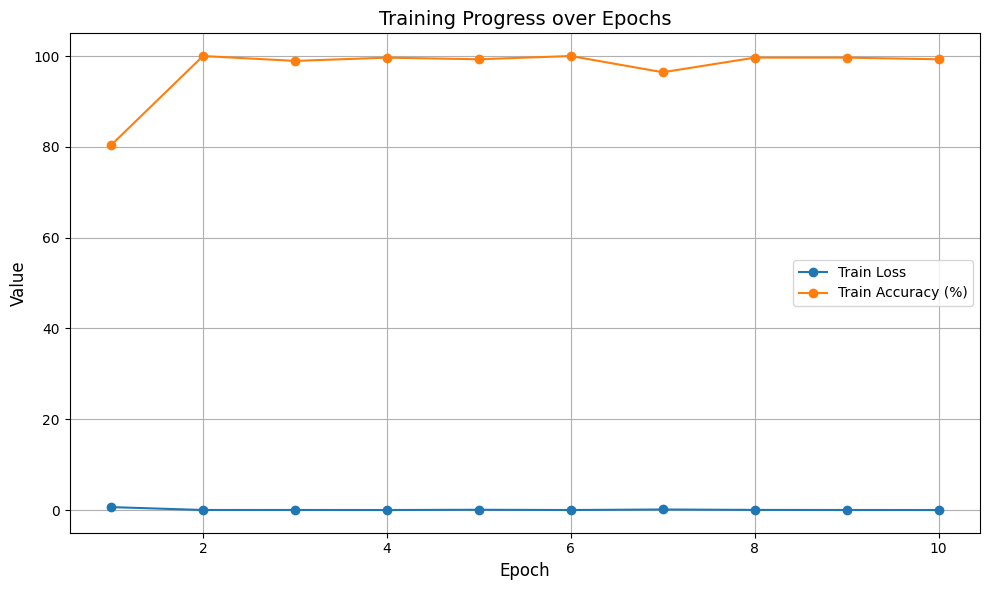

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training log
log = pd.read_csv("training_log.csv")

# Plotting
plt.figure(figsize=(10,6))
plt.plot(log["epoch"], log["train_loss"], marker='o', label="Train Loss")
plt.plot(log["epoch"], log["train_acc"], marker='o', label="Train Accuracy (%)")
if "val_acc" in log.columns:
    plt.plot(log["epoch"], log["val_acc"], marker='o', label="Val Accuracy (%)")

plt.title("Training Progress over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("training_progress.png")
plt.show()


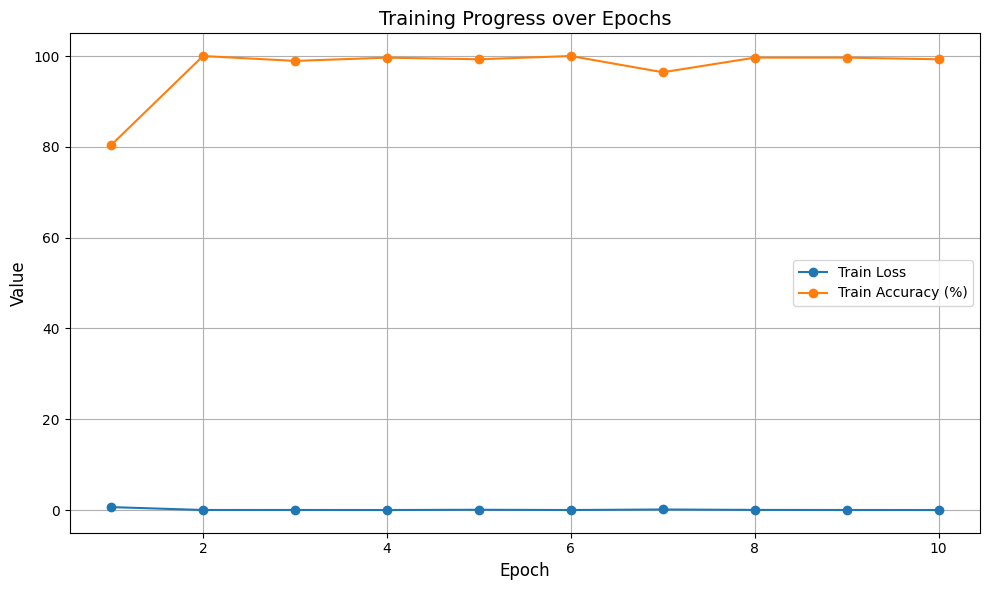

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training log
log = pd.read_csv("training_log.csv")

# Plotting
plt.figure(figsize=(10,6))
plt.plot(log["epoch"], log["train_loss"], marker='o', label="Train Loss")
plt.plot(log["epoch"], log["train_acc"], marker='o', label="Train Accuracy (%)")
if "val_acc" in log.columns:
    plt.plot(log["epoch"], log["val_acc"], marker='o', label="Val Accuracy (%)")

plt.title("Training Progress over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"E:\gridreslt\training_progress.png")
plt.show()
